# Tutorial 02 - Loading and Visualizing Exported Surface Data

In this tutorial we will look at how to load surface data that was exported from Pupil Player into Python to generate heatmaps. We will follow these steps:

1. Load the data using `Pandas`
1. Visualize gaze data for a surface as a heatmap.

Raw Recording Data: To execute this notebook, download the [sample recording](https://drive.google.com/file/d/1vzjZkjoi8kESw8lBnsa_k_8hXPf3fMMC/view?usp=sharing). Unzip and move it into the `recordings` directory for this repository.

## 1 - Loading libraries and reference image

In this example, a participant is looking at a magazine.
Multiple pages of the magazine are tracked as [surfaces](https://docs.pupil-labs.com/core/software/pupil-capture/#surface-tracking). For this tutorial, we will analyze the magazine cover.

First, let's load the reference image of the magazine cover from a file.

Cover Reference Image


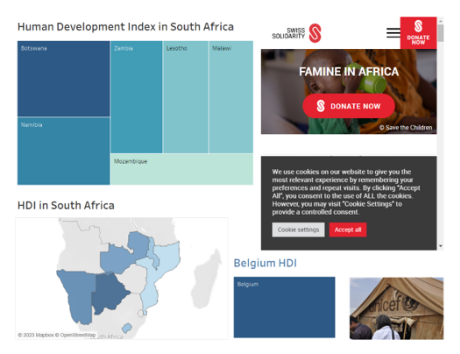

In [20]:
import numpy as np
import matplotlib.pyplot as plt

cover_img = plt.imread('data/dashboard_image.png')

print("Cover Reference Image")
plt.figure(figsize=(8,8))
plt.imshow(cover_img)
plt.axis('off');

## 2 - Loading Exported Surface Data

Now lets see how to load the exported gaze data for this surface. The file will be named with the pattern `gaze_positions_on_surface_<your-surface-name>.csv`

In [33]:
import os
import pandas as pd
from pathlib import Path

recording_location = Path(".") / "recordings" / "sample_recording_v2"
surface_gaze_export_DB = recording_location / "exports" / "000" / "surfaces" / "gaze_pos_DB.csv"
surface_gaze_export_Donate = recording_location / "exports" / "000" / "surfaces" / "gaze_positions_on_surface_DonateAOI.csv"
surface_gaze_export_Other = recording_location / "exports" / "000" / "surfaces" / "gaze_positions_on_surface_OtherInfoAOI.csv"

surface_df = pd.read_csv(surface_gaze_export_DB)

print("Columns in surface data frame:")
list(surface_df.columns)

Columns in surface data frame:


['world_timestamp',
 'world_index',
 'gaze_timestamp',
 'x_norm',
 'y_norm',
 'x_scaled',
 'y_scaled',
 'on_surf',
 'confidence']

### Individual Datums

As we can see the data frame contains only a few columns. Let's review what each column is used for:

- `world_timestamp` - The world camera timestamp at which the sample was recorded.
- `world_index` - The frame number of the world camera to which this sample is correlated.
- `gaze_timestamp` - The timestamp of the gaze position which is correlated with this world frame (note that there can be many gaze positions per world frame due to higher sampling rate of eye cameras relative to world cameras)
- `x_norm` - the normalized x position of the gaze relative to the surface. (0,0) is the bottom left corner of the surface; (1,1) is the top right corner of the surface. Note that coordinates outside of the 0-1 bounds are possible which means that the gaze is **not** on the surface. 
- `y_norm` - the normalized y position of the gaze relative to the surface.
- `x_scaled` and `y_scaled` - the position of the gaze relative to the surface scaled relative to the specified size of the surface. The size is defined in Pupil Player or Pupil Capture. 
- `on_surf` - boolean value if gaze is within the bounds of the surface
- `confidence` - confidence of the pupil detection

Let's take a look at a few values from our sample surface data!

In [34]:
gaze_on_surf = surface_df[surface_df.on_surf == True]
pd.options.display.float_format = '{:.3f}'.format

print("Sample gaze on magazine cover:")
gaze_on_surf.head(5)

Sample gaze on magazine cover:


,world_timestamp,world_index,gaze_timestamp,x_norm,y_norm,x_scaled,y_scaled,on_surf,confidence
185,530101.174,19,530101.165,0.397,0.600,0.397,0.600,True,0.874
186,530101.174,19,530101.169,0.263,0.764,0.263,0.764,True,0.865
188,530101.174,19,530101.177,0.263,0.795,0.263,0.795,True,0.750
189,530101.174,19,530101.180,0.324,0.853,0.324,0.853,True,0.864
190,530101.174,19,530101.184,0.329,0.870,0.329,0.870,True,0.757


We could take this example further by filtering out low `confidence` pupil detection values:

In [35]:
gaze_on_surf = surface_df[(surface_df.on_surf == True) & (surface_df.confidence > 0.8)]
pd.options.display.float_format = '{:.3f}'.format

print("Sample gaze on magazine cover:")
gaze_on_surf.head(5)

Sample gaze on magazine cover:


,world_timestamp,world_index,gaze_timestamp,x_norm,y_norm,x_scaled,y_scaled,on_surf,confidence
185,530101.174,19,530101.165,0.397,0.600,0.397,0.600,True,0.874
186,530101.174,19,530101.169,0.263,0.764,0.263,0.764,True,0.865
189,530101.174,19,530101.180,0.324,0.853,0.324,0.853,True,0.864
191,530101.174,19,530101.188,0.320,0.886,0.320,0.886,True,0.843
192,530101.206,20,530101.192,0.367,0.883,0.367,0.883,True,0.860


## 3 - Visualize aggregate gaze on surface

Now we visualize high confidence gaze data on this surface.

Cover image with heatmap overlay


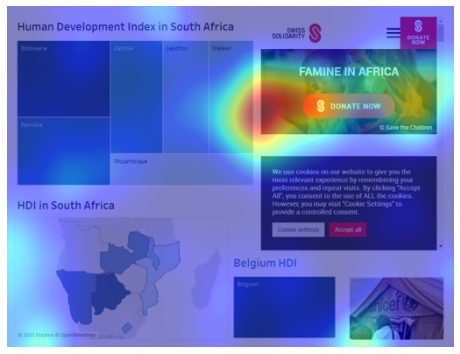

In [36]:
from scipy.ndimage.filters import gaussian_filter

grid = cover_img.shape[0:2] # height, width of the loaded image
heatmap_detail = 0.05 # this will determine the gaussian blur kerner of the image (higher number = more blur)

gaze_on_surf_x = gaze_on_surf['x_norm']
gaze_on_surf_y = gaze_on_surf['y_norm']

# flip the fixation points
# from the original coordinate system,
# where the origin is at botton left,
# to the image coordinate system,
# where the origin is at top left
gaze_on_surf_y = 1 - gaze_on_surf_y

# make the histogram
hist, x_edges, y_edges = np.histogram2d(
    gaze_on_surf_y,
    gaze_on_surf_x,
    range=[[0, 1.0], [0, 1.0]],
    normed=False, 
    bins=grid
)

# gaussian blur kernel as a function of grid/surface size
filter_h = int(heatmap_detail * grid[0]) // 2 * 2 + 1
filter_w = int(heatmap_detail * grid[1]) // 2 * 2 + 1
heatmap = gaussian_filter(hist, sigma=(filter_w, filter_h), order=0)

# display the histogram and reference image
print("Cover image with heatmap overlay")
plt.figure(figsize=(8,8))
plt.imshow(cover_img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off');